 #

# Ci421a Project - Adult data set

#### Objective : Predict, according to some characteristics, if a person earns more than $50K per year or not


We import the librairies we need to read the datas and analyse it.

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from spacy.compat import pickle
import seaborn as sns
import numpy as np
import itertools
import warnings

warnings.filterwarnings('ignore')

We open and read the data files. We have two separated files : one containing training data and another for the test.

In [3]:
df = pd.read_csv('data/Modified_SQL_Dataset.csv')

print(df.head())

print('\nShape of train set:', df.shape)

                                               Query  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1  create user name identified by pass123 tempora...      1
2   AND 1  =  utl_inaddr.get_host_address   (    ...      1
3   select * from users where id  =  '1' or @ @1 ...      1
4   select * from users where id  =  1 or 1#"  ( ...      1

Shape of train set: (30919, 2)


## 1 - Quick dataset analysis

Now that the dataset is imported in the jupyter file, we can start exploring, digging in the datas to see what it is composed of, understand the variables in it, the possible links between them, find the target etc. This step is very important because it allows the user to understand the meaning of datasets, see if information has to be changed, or removed and also start thinking about how datas should be used with the future implemented model.

### A) Dataset cleaning and verifications



First, we check if there are repetitions of observations in the dataset.

In [4]:
df_train = df.drop_duplicates()
print('Shape of train set:', df.shape)

Shape of train set: (30919, 2)


### B) Analysis of the datasets

We can start by displaying some charcteristics in order to know the size of the dataset and what's inside.

In [5]:
columnNames = df.columns
datasetShape = df.shape
variablesTypes = df.dtypes
variablesTypesCount = df.dtypes.value_counts()

print('Column names:', columnNames, '\n')
print('Dataset shape:', datasetShape, '\n')
print('Variables types:', variablesTypes, '\n')
print('Variables types count:', variablesTypesCount)

Column names: Index(['Query', 'Label'], dtype='object') 

Dataset shape: (30919, 2) 

Variables types: Query    object
Label     int64
dtype: object 

Variables types count: object    1
int64     1
Name: count, dtype: int64


### C) Analysis of the target variable

Repartition of the target:
 Label
0    19529
1    11378
Name: count, dtype: int64

Type of this variable: int64


[Text(0, 0, 'benign'), Text(0, 1, 'SQL injection attacks')]

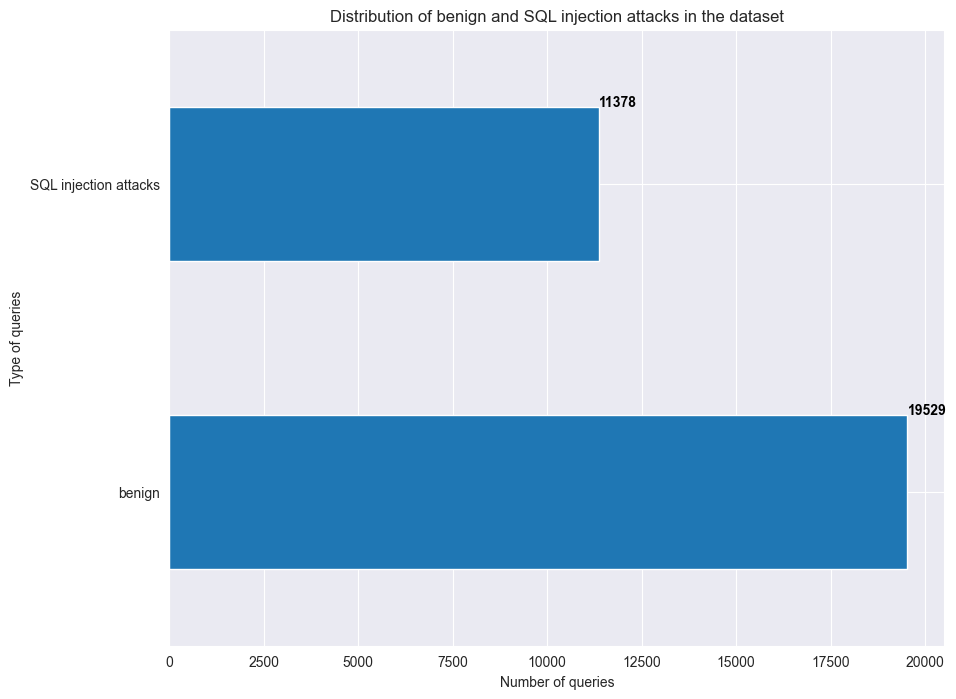

In [6]:
count_target = df_train['Label'].value_counts()
target_type = df_train['Label'].dtype

print('Repartition of the target:\n', count_target)
print('\nType of this variable:', target_type)

# plot the distribution of benign and SQL injection attacks in the dataset
plt.figure(figsize=(10, 8))
plt.title('Distribution of benign and SQL injection attacks in the dataset')
ax = count_target.plot(kind='barh')
ax.set_xlabel('Number of queries')
ax.set_ylabel('Type of queries')
for i, v in enumerate(count_target):
    ax.text(v + 3, i + .25, str(v), color='black', fontweight='bold')

# change 0 and 1 by benign and SQL injection attacks
ax.set_yticklabels(['benign', 'SQL injection attacks'])


## 2 - Pre-processing

In [7]:
from sklearn.model_selection import train_test_split

First, we make a copy of the original datasets.

In [8]:
df_copy = df.copy()

We can finally build the matrices X and y for the train and  test sets

In [9]:
X = df['Query']
y = df['Label']

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# tokenize the query column

In [11]:
# import the necessary libraries
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Lire le dataset CSV
df = pd.read_csv('data/Modified_SQL_Dataset.csv')

# Sélectionner la colonne Query
queries = df['Query'].tolist()

# Initialiser le stemmer et le set de stop words
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Préprocessing du texte
processed_queries = []
padded_sequences = []
for query in queries:
    # Mettre en minuscule
    query = query.lower()

    # Tokenization
    tokens = query.split()

    # Supprimer les stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Rejoindre les tokens
    processed_query = ' '.join(tokens)

    # Ajouter à la liste
    processed_queries.append(processed_query)

# Tokenization des queries préprocessées
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_queries)
sequences = tokenizer.texts_to_sequences(processed_queries)

# Padding des séquences à longueur fixe
padded_sequences = pad_sequences(sequences, maxlen=50)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



# split the dataset into train and test sets

In [12]:
import os.path

if os.path.exists('trained_model_sql_injection.pickle'):
    print('Loading trained model...')
    model = pickle.load(open('trained_model_sql_injection.pickle', 'rb'))
    print("*************************************************************************")
    print("Model loaded, you can now go to the last cell to make a prediction")
    print("*************************************************************************")
else:
    print('Creating and training a new model...')
    print("Run all the cells below")

Loading trained model...
*************************************************************************
Model loaded, you can now go to the last cell to make a prediction
*************************************************************************


In [13]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)
# print the shape of the train and test sets
print('Shape of train set:', X_train.shape)
print('Shape of test set:', X_test.shape)
print(X_train)


Shape of train set: (24735, 50)
Shape of test set: (6184, 50)
[[    0     0     0 ...  7508  7509  7509]
 [    0     0     0 ...  6289  6390  3281]
 [    0     0     0 ... 25322 25323  3658]
 ...
 [    0     0     0 ...   956   349     2]
 [    0     0     0 ... 22685  9321  2698]
 [    0     0     0 ...  4888    61    12]]


# Test several machine learning models on our data

In [14]:
# create an Machine learning algorithm to predict the target variable
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
    
# create a dictionary of models
models = {'Logistic Regression': LogisticRegression(),
          'Random Forest': RandomForestClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Support Vector Machine': SVC(),
          'K-Nearest Neighbors': KNeighborsClassifier()}

# create a function to train and evaluate the models
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    # train the model
    model.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)

    # print the accuracy score
    print('Accuracy:', accuracy_score(y_test, y_pred), '\n')

    # print the confusion matrix
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred), '\n')

    # print the classification report
    print('Classification Report:\n', classification_report(y_test, y_pred))

    # apply k-fold cross validation
    accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)
    print('10-fold Cross Validation:\n', accuracies.mean())
    
# train and evaluate the models
for name, model in models.items():
    print(name, '\n')
    train_and_evaluate(model, X_train, y_train, X_test, y_test)
    print('\n\n')
    

Logistic Regression 
Accuracy: 0.7514553686934023 

Confusion Matrix:
 [[3595  298]
 [1239 1052]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.92      0.82      3893
           1       0.78      0.46      0.58      2291

    accuracy                           0.75      6184
   macro avg       0.76      0.69      0.70      6184
weighted avg       0.76      0.75      0.73      6184
10-fold Cross Validation:
 0.7507982573965358



Random Forest 
Accuracy: 0.9959573091849935 

Confusion Matrix:
 [[3878   15]
 [  10 2281]] 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3893
           1       0.99      1.00      0.99      2291

    accuracy                           1.00      6184
   macro avg       1.00      1.00      1.00      6184
weighted avg       1.00      1.00      1.00      6184
10-fold Cross Validation:
 0.9956337989494297



Decision

In [15]:
# save the best accuracy model using pickle
import pickle

# save the model to disk
filename = 'trained_model_sql_injection.pickle'
pickle.dump(models['Random Forest'], open(filename, 'wb'))


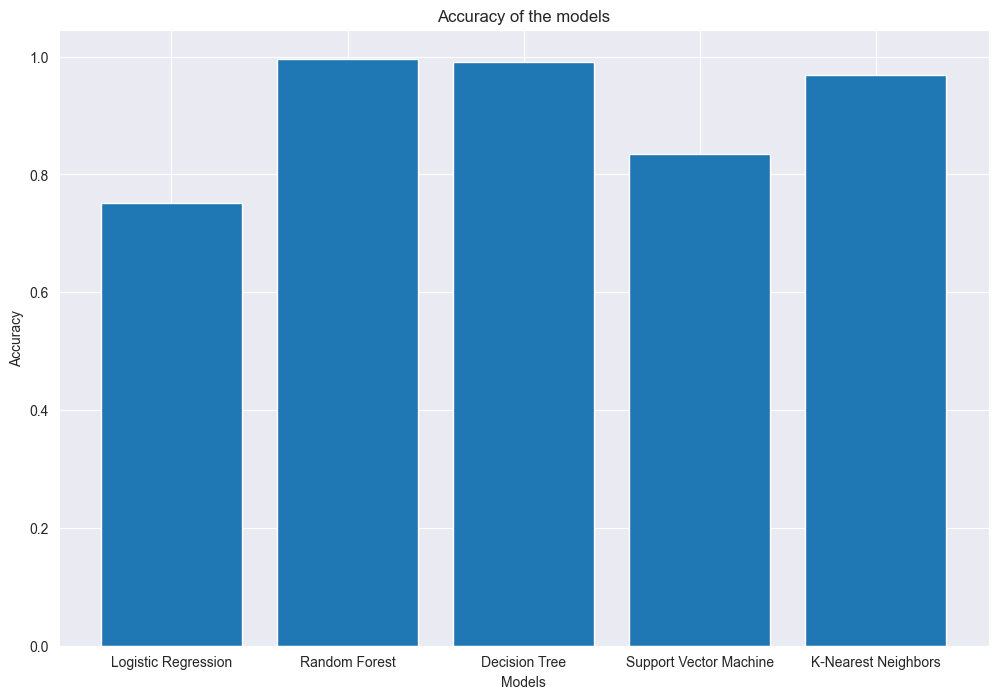

In [16]:
# plot the accuracy of the models
plt.figure(figsize=(12, 8))
plt.title('Accuracy of the models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.bar(list(models.keys()), [accuracy_score(y_test, model.predict(X_test)) for model in models.values()])
plt.show()


# Create a deep neural network model with keras

We create a simple DNN model with keras, then we fit it on the train set and evaluate it on the test set. Finally we save the model to use it in our web application.

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# define input sequence shape
sequence_length = X_train.shape[1]

# define the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=sequence_length))
model.add(Dropout(0.5))  # add dropout
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # add L2 regularization

# compile the model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# save history
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Save the model
model.save('sql_injection_model.h5')

Epoch 1/10
773/773 [==============================] - 10s 12ms/step - loss: 0.2962 - accuracy: 0.9098 - val_loss: 0.1816 - val_accuracy: 0.9635
Epoch 2/10
773/773 [==============================] - 9s 12ms/step - loss: 0.1537 - accuracy: 0.9758 - val_loss: 0.1413 - val_accuracy: 0.9821
Epoch 3/10
773/773 [==============================] - 9s 12ms/step - loss: 0.1198 - accuracy: 0.9827 - val_loss: 0.1285 - val_accuracy: 0.9753
Epoch 4/10
773/773 [==============================] - 10s 13ms/step - loss: 0.1017 - accuracy: 0.9852 - val_loss: 0.1139 - val_accuracy: 0.9806
Epoch 5/10
773/773 [==============================] - 11s 14ms/step - loss: 0.0900 - accuracy: 0.9859 - val_loss: 0.1044 - val_accuracy: 0.9825
Epoch 6/10
773/773 [==============================] - 10s 13ms/step - loss: 0.0805 - accuracy: 0.9877 - val_loss: 0.0989 - val_accuracy: 0.9837
Epoch 7/10
773/773 [==============================] - 12s 15ms/step - loss: 0.0735 - accuracy: 0.9891 - val_loss: 0.0955 - val_accuracy: 0

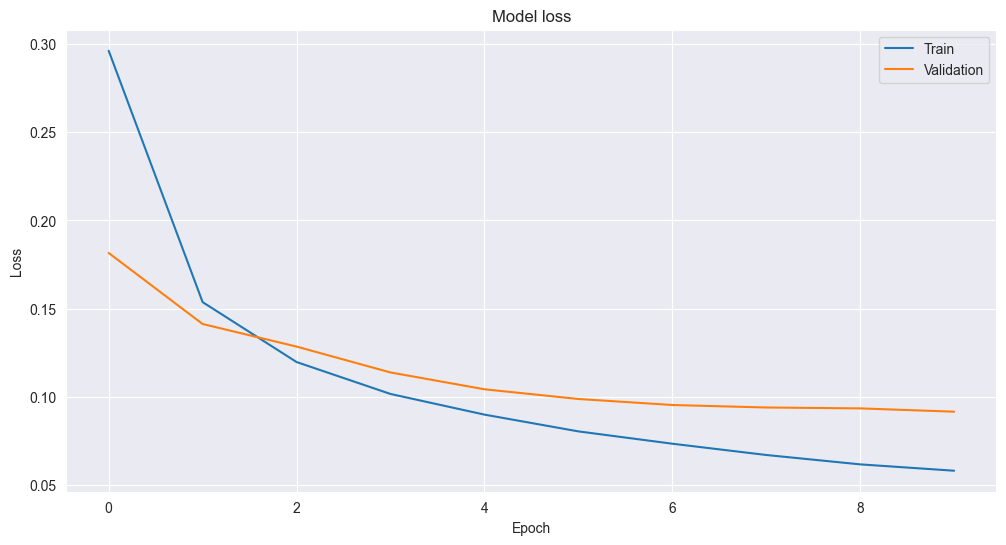

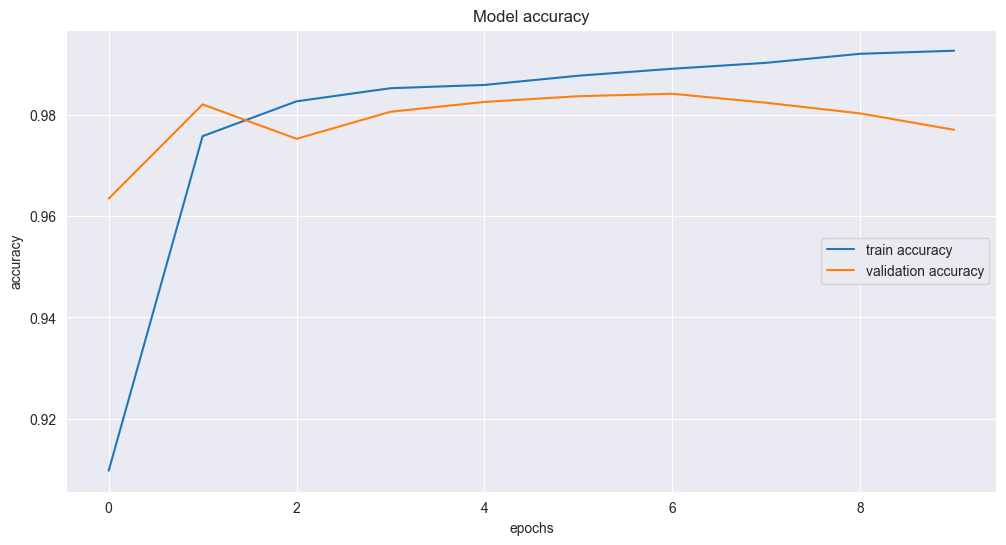

In [18]:
# Import the necessary library
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Afficher l'historique de l'accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train accuracy', 'validation accuracy'], loc='right')
plt.show()


In [19]:
# import necessary libraries
from keras.preprocessing.sequence import pad_sequences

# define the SQL statement
sql_statement = "SELECT * FROM employees WHERE department = 'Sales'"
sql_statement2 = "SELECT ItemName, ItemDescription FROM Items WHERE ItemNumber = 999 or 1=1"

# preprocess the SQL statement
# convert to lowercase
sql_statement = sql_statement.lower()
sql_statement2 = sql_statement2.lower()
# tokenize
tokens = sql_statement.split()
tokens2 = sql_statement2.split()

# remove stop words
tokens = [word for word in tokens if word not in stop_words]
tokens2 = [word for word in tokens2 if word not in stop_words]

# apply stemming
tokens = [stemmer.stem(word) for word in tokens]
tokens2 = [stemmer.stem(word) for word in tokens2]

# join the tokens
processed_query = ' '.join(tokens)
processed_query2 = ' '.join(tokens2)

# convert text to sequences
sequences = tokenizer.texts_to_sequences([processed_query])
sequences2 = tokenizer.texts_to_sequences([processed_query2])

# pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=50)
padded_sequences2 = pad_sequences(sequences2, maxlen=50)

# make prediction
prediction = model.predict(padded_sequences)
prediction2 = model.predict(padded_sequences2)

if (prediction > 0.5):
    statement = 'SQL injection attack'
else:
    statement = 'benign'

if (prediction2 > 0.5):
    statement2 = 'SQL injection attack'
else:
    statement2 = 'benign'

# print the prediction
print('Prediction:', prediction, 'La requête est', statement)
print('Prediction:', prediction2, 'La requête est', statement2)

1/1 [==============================] - 0s 34ms/step
Prediction: [[0.00878892]] La requête est benign
Prediction: [[0.9663479]] La requête est SQL injection attack


We are testing the precision of our model

In [20]:
# test the precision of our model
from sklearn.metrics import precision_score

# make predictions
y_pred = model.predict(X_test)

# convert the predictions to binary
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# print the precision score
print('Precision:', precision_score(y_test, y_pred))

194/194 [==============================] - 0s 2ms/step
Precision: 0.9967637540453075


The dataset is not so complex, so the model gives good results with a good precision.